# Use of StructureFunction package

The structure function is implemented using the formula from Roelens+17 :

\begin{equation}
SF(\tau_1, \tau_2) = \frac{1}{p(\tau_1, \tau_2)} \sum{(mag_i - mag_j)^2}
\end{equation}

## Libraries, initialization

In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

sys.path.append('../../JR_QMindex/variability')

import StructureFunction as     SF

In [2]:
#Synthetic light curve
def sine(period, amp, med_mag, sig, times, uncert) :
    noise    = np.random.normal(uncert, sig, len(times))
    mag      = med_mag + amp/2 * np.sin(2 * np.pi * (times - min(times))/period) + noise
    return mag, noise

## Create a lc

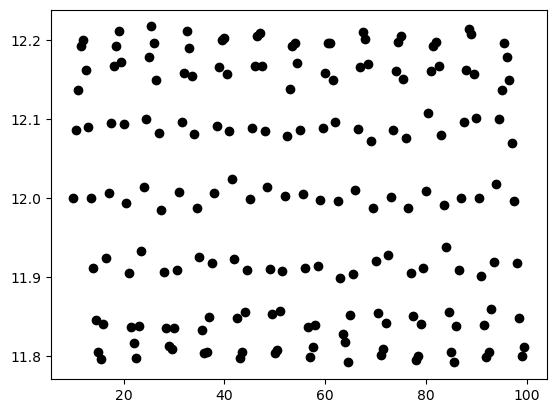

In [3]:
times      = np.arange(10, 100, 0.5)

period, amp, med_mag, sig, uncert = 7, 0.4, 12, 0.01, 0.001
mag, noise = sine(period, amp, med_mag, sig, times, uncert)

plt.scatter(times, mag, c='black')

## Structure function and timescale

In [4]:
# Args of the SF :

epsilon = 4    
'''Epsilon : minimum nb of pairs required at a given time lag to compute the sf. 
If no pair is found in the original time bin at a given t_log, sf(t_log)=nan. 
If 0 < nb pairs < epsilon, the time bin will be increased at both sides of t_log before re-computing sf(t_log)
'''
num_bins = len(times)
'''num_bins : the nb of bins of the array t_log. 
If it's too large compared to the lenght of the time series, there is a risk of overfitting of the sf
'''


#Compute the SF
sf, t_log, it   = SF.structure_function_slow(mag, times-min(times), num_bins = num_bins, epsilon = epsilon)

Text(0, 0.5, 'nb pairs delta_tau = time lag')

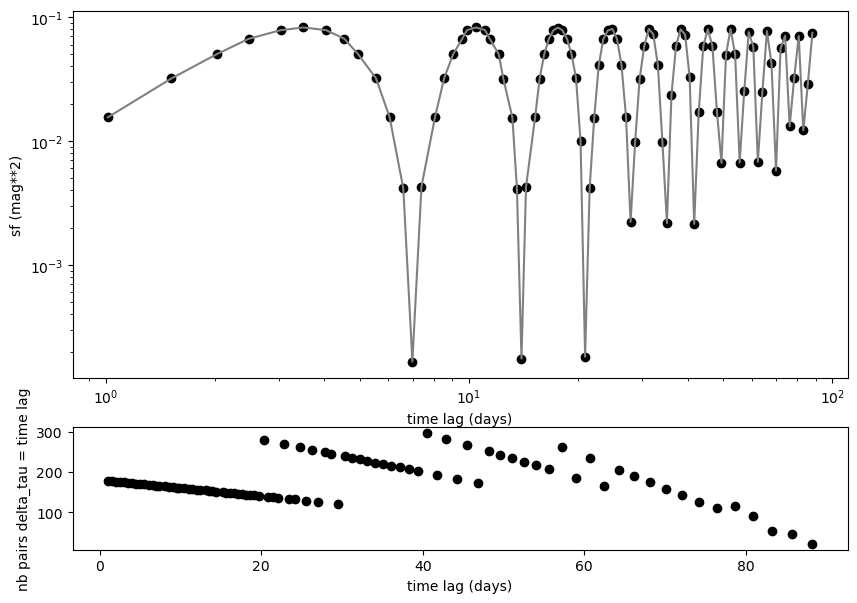

In [5]:
#Plot
fig, ax = plt.subplots(2, 1, figsize = (10, 7), gridspec_kw={'height_ratios': [3, 1]})


ax[0].scatter(t_log, sf, c = 'black')
ax[0].plot(t_log, sf, c = 'grey')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('time lag (days)')
ax[0].set_ylabel('sf (mag**2)')

ax[1].scatter(t_log, it, c = 'black')
ax[1].set_xlabel('time lag (days)')
ax[1].set_ylabel('nb pairs delta_tau = time lag')

The timescale tau_peak can be retrieved from the sf using find_timescale. In case the time series is aperiodic, this function should return half the period.


In [6]:
#Get the timescale

err = np.mean(noise)
'''err is the noise of the light curve. It is used to define the noise-dominated regime of the time-series
When working with real data, I used noise = np.mean(e_Gmag) 
'''
thresh = 75
''' thresh is the _th centile that is used for a first approximation of tau_peak
tau_peak is the crossing point between the sf's 2nd and 3rd regime, and the point where most variability occurs
lower thresh (~60) tends to be less reliable. The resulting ts is more often wrong and sometimes nan
higher thresh (~90) can lead to a big overestimation of the ts, especially for long periods (>= 20 days with gaia
'''


ts , dict_fit, flag          = SF.find_timescale(sf, t_log, err = err, thresh = thresh)
print(f'timescale retrieved from the code : {ts} days')
print(f'input period : {period} ; period from the SF {2 * np.round(ts, 3)}')

timescale retrieved from the code : 3.498122193983514 days
input period : 7 ; period from the SF 6.996


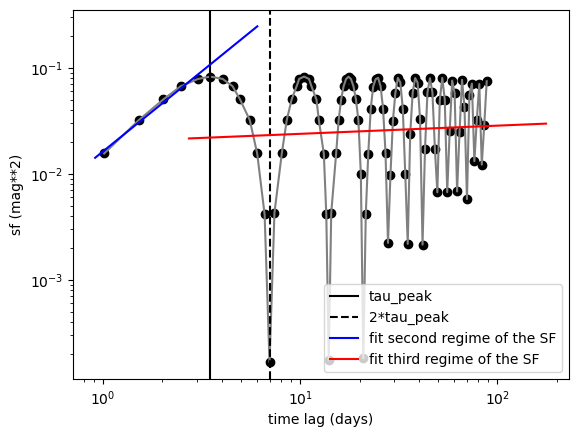

In [7]:
#Plot
colors = ['green', 'blue', 'red']
labels = ['first', 'second', 'third']

plt.scatter(t_log, sf, c = 'black')
plt.plot(t_log, sf, c = 'grey')

plt.axvline(ts, c = 'black', label = 'tau_peak')
plt.axvline(2*ts, c = 'black', label = '2*tau_peak', ls = '--')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('time lag (days)')
plt.ylabel('sf (mag**2)')


for i in range(1, 3) :
    
    if len(dict_fit[f't_{i}']) > 0 :
        plt.plot(dict_fit[f't_{i}'], dict_fit[f'sf_{i}'], c = colors[i], label = f'fit {labels[i]} regime of the SF')
        
plt.legend(loc = 'lower right')